

# Vaccine Prioritizations using Cellular Automata

The COVID-19 pandemic has caused a major crisis worldwide, with case transmissions between individuals still occurring on a wide scale. In an effort to decrease the case transmissions in the long term, COVID-19 vaccines are urgently required to be distributed to the population. However, a limited quantity of the COVID-19 vaccines is available to be administered. This raises concerns on how to prioritize the COVID-19 vaccine doses among the population. The goal of this part of the the project is to apply the Cellular Automata Model to achieve a well motivated and data-driven decision on which age group to prioritize in the vaccine distribution plan with the goal of slowing down infection and death rates to protect the general population from the effects of the COVID-19 virus. 

This part analyzes COVID-19 vaccination prioritization using the Cellular Automata Model, where the cells in the model represent the demographics of the United States population with each cell having one of the following possible states: (1) Susceptible $S$, (2) Symptomatically Infected $I_S$, (3) Asymptomatically Infected $I_A$, (4) Recovered $R$, (5) Deceased $D$, or (6) Vaccinated $V$. With this configuration, we aim to display the spread of the COVID-19 virus simultaneously with the active distribution of the COVID-19 vaccine to the population while prioritizing each of the age groups under consideration. Using the data from this model, we discuss the effectiveness of prioritizing each age group according to reductions in deaths and infections.

# Setting up the model
Includes all the helper functions and parameters needed to run the Cellular Automata Model.

We import the following packages which will be used throughout the notebook:


1.   **NumPy**: Adds support for large and multi-dimentional arrays.
2.   **MatPlotLib**: Powerful tool to generate data plots.
3.   **Random**: Allows for generating random numbers and samples from various distributions.
4.   **iPyWidgets**: Interactive sliders for plots to visualize changes in input parameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import interact

In our $n x n$ grid $W = W(t)$, cells evolve over time. Where time $t$ is measured in days. Every cell in $W$ could be in one of the following possible states:

*   **SUSCEPTIBLE ($S$):** The cell has not contracted the virus and can be infected if they are surrounded by infected cells. All cells are initially susceptible.
*   **ASYMPTOMATICALLY INFECTED ($I_a$):** The cell is infected with the virus but is *not aware* of the infection. It has a *higher probability* of spreading the virus to neighboring cells.
*   **SYMPTOMATICALLY INFECTED ($I_s$):** The cell is infected with the virus but is *aware* of the infection. It has a *lower probability* of spreading the virus due to quarantining measures, and can only infect immediate cells.
*   **RECOVERED ($R$):** The cell has fully recovered from the virus. It cannot be reinfected or infect other cells.
*   **DECEASED ($D$):** The cell has passed away from the virus.
*   **VACCINATED ($V$):** The cell has been fully vaccinated, *yay*! It has full immunity and cannot be infected or infect other cells.

The transition between states is displayed by the following figure:
<br>
<div>
<center><img src="https://drive.google.com/uc?id=13WfkYysqmit57YEroPHzhbfDqMFsn9qd" style="center"; width="400"/></center>
</div>


The associated integers for each state are:

In [ ]:
EMPTY = -1
SUSCEPTIBLE = 0
ASYMP_INFECTED = 1
SYMP_INFECTED = 2
RECOVERED = 3
DECEASED = 4
VACCINATED = 5

The following function builds our 2D grid $W$ and visualizes the 2D world. Each possible state is taken into consideration and plotted with a unique color on the spectrum:

In [ ]:
def createGrid(world, vmin=EMPTY, vmax=VACCINATED, states="states"):
  assert states in ["states", "bool"]
  if (states == "states"):
    ticks = range(vmin, vmax+1)
    labels = ['Empty', 'Susceptible', 'Asymptomatic Infected', 'Symptomatic Infected', 'Recovered', 'Deceased', 'Vaccinated']
  else:
    ticks = [0,1]
    labels = ['False (0)', 'True (1)']

  plt.pcolor(world, vmin=vmin, vmax=vmax, edgecolor='black')
  colorBar = plt.colorbar()
  colorBar.set_ticks(ticks)
  colorBar.set_ticklabels(labels)
  plt.axis('square')
  h = world.shape[0]-2
  w = world.shape[1]-2
  plt.axis([0, h+2, 0, w+2])

The following functions help us in extracting useful information for the cells on the grid $W$. Each possible state has its own helper function for more effective use throughout the notebook.
<br>
<br>
Each state helper function provides the following information:

1.   Locations of all cells in the grid $W$ that are of that state.
2.   Number of all cells in the grid $W$ that are of that state.
3.   Ratio of the cells of that state with respect to the total number of cells in the grid $W$.

In [ ]:
def susceptible(grid):
  locationsSusceptible = (grid == SUSCEPTIBLE).astype(int)
  numberSusceptible = len(np.where(grid == SUSCEPTIBLE)[0])
  ratioSusceptible = numberSusceptible / ((grid.shape[0]-2) * (grid.shape[1]-2))
  return locationsSusceptible, numberSusceptible, ratioSusceptible

def asympInfected(grid):
  locationsAsympInfected = (grid == ASYMP_INFECTED).astype(int)
  numberAsympInfected = len(np.where(grid == ASYMP_INFECTED)[0])
  ratioAsympInfected = numberAsympInfected / ((grid.shape[0]-2) * (grid.shape[1]-2))
  return locationsAsympInfected, numberAsympInfected, ratioAsympInfected

def sympInfected(grid):
  locationsSympInfected = (grid == SYMP_INFECTED).astype(int)
  numberSympInfected = len(np.where(grid == SYMP_INFECTED)[0])
  ratioSympInfected = numberSympInfected / ((grid.shape[0]-2) * (grid.shape[1]-2))
  return locationsSympInfected, numberSympInfected, ratioSympInfected

def recovered(grid):
  locationsRecovered = (grid == RECOVERED).astype(int)
  numberRecovered = len(np.where(grid == RECOVERED)[0])
  ratioRecovered = numberRecovered / ((grid.shape[0]-2) * (grid.shape[1]-2))
  return locationsRecovered, numberRecovered, ratioRecovered

def deceased(grid):
  locationsDead = (grid == DECEASED).astype(int)
  numberDead = len(np.where(grid == DECEASED)[0])
  ratioDead = numberDead / ((grid.shape[0]-2) * (grid.shape[1]-2))
  return locationsDead, numberDead, ratioDead

def vaccinated(grid):
  locationsVacc = (grid == VACCINATED).astype(int)
  numberVacc = len(np.where(grid == VACCINATED)[0])
  ratioVacc = numberVacc / ((grid.shape[0]-2) * (grid.shape[1]-2))
  return locationsVacc, numberVacc, ratioVacc

The virus spreads among individuals symptomatically and asymptomatically. Likewise, at each time step in our simulation, the cells can either become symptomatically infected or asymptomatically infected according to the following conditions:

**Asymptomatic Spread:** The cell unknowingly spreads the virus to surrounding cells, so there is a higher probability of spread. The asymptomatic spread of the virus is indirectly proportional to the distance between the cell and its neighbors. The following quantifies asymptomatic spread:

*   Cells **1** block away are infected with a probability of $asympRate\%$
*   Cells **2** blocks away are infected with a probability of $asympRate^2\%$
*   Cells **3** blocks away are infected with a probability of $asympRate^3\%$

**Symptomatic Spread:** Cells that are symptomatic will immediately quarantine safely away from others, so they only have the ability to infect cells that are 1 block away with a probability of $sympRate\%$.

The only cells that have the ability to be infected are ones in the state ***susceptible***. All vaccinated, recovered, and deceased cells have full protection from infection and spread.

The following function calculates the probability that the susceptible cells in the grid $W$ become either symptomatically and asymptomatically infected:

In [ ]:
def infectionSpreadProbability(grid, asympRate, sympRate):
  suscep = susceptible(grid)[0]
  asympInfect = asympInfected(grid)[0]
  sympInfect = sympInfected(grid)[0]
  asymp1 = np.zeros(shape=grid.shape, dtype=int)
  asymp2 = np.zeros(shape=grid.shape, dtype=int)
  asymp3 = np.zeros(shape=grid.shape, dtype=int)
  symp = np.zeros(shape=grid.shape, dtype=int)

  #Asymptomatic spread
  asymp1[3:-3, 3:-3] = asympInfect[2:-4, 3:-3] | asympInfect[3:-3, 4:-2] | asympInfect[4:-2, 3:-3] | asympInfect[3:-3, 2:-4]
  asymp1 = asymp1 & suscep
  asympProbability1 = asympRate * asymp1

  asymp2[3:-3, 3:-3] = asympInfect[1:-5, 3:-3] | asympInfect[3:-3, 5:-1] | asympInfect[5:-1, 3:-3] | asympInfect[3:-3, 1:-5]
  asymp2 = asymp2 & suscep
  asympProbability2 = (asympRate**2) * asymp2

  asymp3[3:-3, 3:-3] = asympInfect[0:-6, 3:-3] | asympInfect[3:-3, 6:] | asympInfect[6:, 3:-3] | asympInfect[3:-3, 0:-6]
  asymp3 = asymp3 & suscep
  asympProbability3 = (asympRate**3) * asymp3

  #Symptomatic spread
  symp[3:-3, 3:-3] = sympInfect[2:-4, 3:-3] | sympInfect[3:-3, 4:-2] | sympInfect[4:-2, 3:-3] | sympInfect[3:-3, 2:-4]
  symp = symp & suscep
  sympProbability = sympRate * symp

  totalProbability = asympProbability1 + asympProbability2 + asympProbability3 + sympProbability
  
  return totalProbability

If a cell is asymptomatic, there is a latent period of **3 days**, after which the cell becomes symptomatically infectious. This function keeps track of all the *asymptomatically infectious* cells and changes their state to the *symptomatically infectious* state after the latent period:

In [ ]:
def updateAsympInfected(grid, asympCells):
  asympInfect = asympInfected(grid)[0]
  asympCells += asympInfect

  becomeSymptomatic = np.where(asympCells > 3)
  asympCells[becomeSymptomatic] = 0
  grid[becomeSymptomatic] = SYMP_INFECTED

Following an infectious period of **5 days**, a symptomatically infectious cell either turns into the *recovered* state with a probability of $recoveryRate\%$ or into the *deceased* state with a probability of $deathRate\%$:

In [ ]:
def updateSympInfected(grid, sympCells, recoveryRate, deathRate):
  sympInfect = sympInfected(grid)[0]
  sympCells += sympInfect
  symp = np.where((sympCells) & (sympCells % 5 == 0))

  for cell in zip(*symp):
    number = random.random()

    if (number < recoveryRate):
      grid[cell] = RECOVERED
      sympCells[cell] = 0
    elif (number < recoveryRate + deathRate):
      grid[cell] = DECEASED
      sympCells[cell] = 0

This function controls the vaccine distribution among cells in the grid $W$. At each time step (each day), we have to vaccinate a total amount of ($vaccineRate$ x $total$ $cells$) cells in the grid $W$. The only cells with the ability to get vaccinated are susceptible cells. The function uses $random.choices$ to get a random selection of susceptible cells from grid $W$ to vaccinate:

In [ ]:
def updateVaccinated(grid, vaccineRate, n):
  cellsToVaccinate = int(vaccineRate * (n*n))
  cellsVaccinated = 0

  susceptibleCells = susceptible(grid)[0]
  sus = list(zip(*np.where(susceptibleCells)))
  cells = random.choices(sus, k=cellsToVaccinate)

  for i in cells:
    grid[i] = VACCINATED
    cellsVaccinated += 1

The initial configuration of the world is made up of susceptible cells with a small fraction, $initialPercent\%$, of asymptomatically infected cells selected at random, representing the ongoing spread of the virus at the beginning stage of vaccination. The world $W$ is an $nxn$ grid of cells. The function also initializes the $asympCells$ and $sympCells$ arrays which track the asymptomatically infected and symptomatically infected cells consecutively:

In [ ]:
def createWorld(n, initialPercent):
  world = EMPTY * np.ones((n+6, n+6))
  asympCells = np.zeros(world.shape, dtype=int)
  sympCells = np.zeros(world.shape, dtype=int)

  world[3:-3, 3:-3] = SUSCEPTIBLE

  numInitialInfected = int((initialPercent/100) * (n*n))
  for _ in range(numInitialInfected):
    position = int(random.random() * n)
    world[position+3, position+3] = ASYMP_INFECTED

  return world, asympCells, sympCells

To simulate the real world as accurately as possible, we have to do the following at each time step:

1.   **Vaccinate cells:** In order to successfully simulate the vaccine prioritization by age group, the function does the following:
     *   It vaccinates an $ageGroupwantVaccine$% of the selected age group for prioritization until the full number of individuals/cells in that age group have been vaccinated.
     *   Once everyone in the prioritized age group has been vaccinated, all other individuals/cells have an equal chance% to get vaccinated next.
2.   **Update asymptomatically infected cells:** This calls the $updateAsympInfected$ function with the current $asympCells$ array in order to update all asymptomatic cells.
3.   **Update symptomatically infected cells:** This calls the $updateSympInfected$ function with the current $sympCells$ array in order to update all symptomatic cells.
4.   **Update susceptible cells:** Each susceptible cell's probability of infection is calculated using the $infectionSpreadProbability$ function. It then iterates through the susceptible cells to infect them based on the calculated infection probability.


In [ ]:
def stepEvolution(grid, ageGroupPopulation, ageGroupwantVaccine, vaccineRolloutRate, asympCells, sympCells):

  numVaccinated = vaccinated(grid)[1]
  if (numVaccinated <= int(ageGroupPopulation*ageGroupwantVaccine*n*n)):
    updateVaccinated(grid, vaccineRolloutRate*ageGroupwantVaccine, n)
  else:
    updateVaccinated(grid, vaccineRolloutRate*averageWantVaccine, n)

  updateAsympInfected(grid, asympCells)
  updateSympInfected(grid, sympCells, recoveryRate, deathRate)

  infectionProbability = infectionSpreadProbability(grid, asympRate, sympRate)

  for (x,y) in zip(*np.where(infectionProbability > 0)):
    number = random.random()

    if (number < infectionProbability[x,y]):
      grid[x,y] = ASYMP_INFECTED

The following are our model parameters:

1.   **timeSteps:** The number of time steps through which the model evolves. Each time step is equal to 1 day.
2.   **n:** The size of the $nxn$ grid $W$.
3.   **asympRate:** The asymptomatic infection rate which is the probability that a susceptible cell is infected one cell ($asympRate$), two cells ($asympRate^2$), or three cells away ($asympRate^3$) which are asymptomatic.
4.   **sympRate:** The symptomatic infection rate which is the probability that a susceptible cell is infected only by direct neighbors which are symptomatic.
5.   **recoveryRate:** The probability that a cell recovers from the virus.
6.   **deathRate:** The probability that a cell passes away from the virus.
7.   **vaccineRolloutRate:** The percentage of the population that is vaccinated per day.
8.   **populationAgeGroups:** This is an array of size 5, where each index represents the percentage of population of an age group:
     * **Under 20**: 24.87%
     * **20-39 years**: 27.20%
     * **40-59 years**: 25.19%
     * **60-79 years**: 18.80%
     * **80+ years**: 3.94%
9.   **wantVaccineAgeGroups:** This is an array of size 5, where each index represents the percentage of each age group that accepts and is not hesitant to take the vaccine :
     * **Under 20**: 75%
     * **20-39 years**: 65%
     * **40-59 years**: 55%
     * **60-79 years**: 75%
     * **80+ years**: 90%
10.   **averageWantVaccine:** This is the average acceptance of the vaccine across all age groups. It is 72%.


It is important to note that all the preceding data was gathered from the most up to date data for the United States.

In [ ]:
#timeSteps = 550
n = 100
asympRate = 0.0274
sympRate = 0.064
recoveryRate = 0.3
deathRate = 0.0181
vaccineRolloutRate = 0.002

numAgeGroups = 5
populationAgeGroups = [0.2487, 0.272, 0.2519, 0.188, 0.0394]
wantVaccineAgeGroups = [0.75, 0.65, 0.55, 0.75, 0.9]
averageWantVaccine = 0
for x in wantVaccineAgeGroups:
  averageWantVaccine += x
averageWantVaccine = averageWantVaccine / numAgeGroups

# Cellular Automata Model

This is the main function of our model. It brings together all the previous functions to create a complete Cellular Automata Model that models both the symptomatic and asymptomatic spread of COVID-19, along with the vaccine rollout, prioritizing a single age group over others. The goal of the model is to apply the Cellular Automata model to achieve a well motivated and data-driven decision on which age group to prioritize in the vaccine distribution, with the goal of slowing down infection and death rates. Hence, the main function takes in, as parameters, the $initialPercentage$ (percentage of the whole population that is initially infected), the $timeSteps$, and the $ageGroup$ (the age group to prioritize for vaccine distribution). Using those parameters, the function creates a new world and iterates through a number of $timeSteps$, with each time step making a call to the appropriate $stepEvolution$ function to prioritize the given age group.
<br></br>
The inputs to the model, $initialPercentage$, $timeSteps$, and $ageGroup$, can be toggled through the sliders available. This helps to better visualize the effects of adjusting the different parameters by interacting with the plot. Feel free to adjust the input parameters to see their effect on the COVID-19 virus spread and vaccine distirbution.

In [ ]:
susceptibleList = []
asympInfectedList = []
sympInfectedList = []
recoveredList = []
deceasedList = []
vaccinatedList = []

def main(initialPercentage, timeSteps, ageGroup):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList.append(suscep/n)
    asympI = asympInfected(world)[1]
    asympInfectedList.append(asympI/n)
    sympI = sympInfected(world)[1]
    sympInfectedList.append(sympI/n)
    recover = recovered(world)[1]
    recoveredList.append(recover/n)
    dead = deceased(world)[1]
    deceasedList.append(dead/n)
    vacc = vaccinated(world)[1]
    vaccinatedList.append(vacc/n)

    if (ageGroup == 1):
      stepEvolution(world, populationAgeGroups[0], wantVaccineAgeGroups[0], vaccineRolloutRate, asympCells, sympCells)
    elif (ageGroup == 2):
      stepEvolution(world, populationAgeGroups[1], wantVaccineAgeGroups[1], vaccineRolloutRate, asympCells, sympCells)
    elif (ageGroup == 3):
      stepEvolution(world, populationAgeGroups[2], wantVaccineAgeGroups[2], vaccineRolloutRate, asympCells, sympCells)
    elif (ageGroup == 4):
      stepEvolution(world, populationAgeGroups[3], wantVaccineAgeGroups[3], vaccineRolloutRate, asympCells, sympCells)
    elif (ageGroup == 5):
      stepEvolution(world, populationAgeGroups[4], wantVaccineAgeGroups[4], vaccineRolloutRate, asympCells, sympCells)

  createGrid(world)

interact(main, 
         initialPercentage = (0, 100, 1), 
         timeSteps = (0, 500, 1), 
         ageGroup = [('Under 20', 1), ('20-39 years', 2), ('40-59 years', 3), ('60-79 years', 4), ('80+ years', 5)])

interactive(children=(IntSlider(value=50, description='initialPercentage'), IntSlider(value=250, description='…

<function __main__.main>

# Cellular Automata simulations prioritizing each age group
This includes runs of the scenarios of the Cellular Automata model for each age group.

Setting up additional model parameters:

*   **initialPercentage:** This is the percentage of the population that is initially infected. This value was chosen as 6%, considering the most up to date data for the US at the time the first vaccines were administered.
*   **timeSteps:** The simulations will be run for a period of 300 days.



In [ ]:
initialPercentage = 6
timeSteps = 300

Simulation run for $ageGroup$ = **Under 20**. This prioritizes the *Under 20* age group for the vaccine distribution.


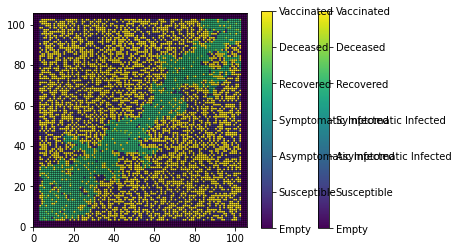

In [ ]:
susceptibleList1 = []
asympInfectedList1 = []
sympInfectedList1 = []
recoveredList1 = []
deceasedList1 = []
vaccinatedList1 = []


def main(initialPercentage, timeSteps):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList1.append(suscep/n)

    asympI = asympInfected(world)[1]
    asympInfectedList1.append(asympI/n)

    sympI = sympInfected(world)[1]
    sympInfectedList1.append(sympI/n)

    recover = recovered(world)[1]
    recoveredList1.append(recover/n)

    dead = deceased(world)[1]
    deceasedList1.append(dead/n)

    vacc = vaccinated(world)[1]
    vaccinatedList1.append(vacc/n)

    stepEvolution(world, populationAgeGroups[0], wantVaccineAgeGroups[0], vaccineRolloutRate, asympCells, sympCells)
  
  createGrid(world)
main(initialPercentage, timeSteps)

tot_inf1 = [sum(x) for x in zip(asympInfectedList1, sympInfectedList1)]

Simulation run for $ageGroup$ = **20-39 years**. This prioritizes the *20-39 years* age group for the vaccine distribution.

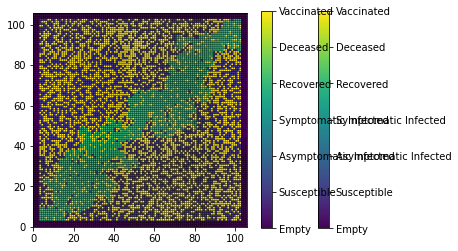

In [ ]:
susceptibleList2 = []
asympInfectedList2 = []
sympInfectedList2 = []
recoveredList2 = []
deceasedList2 = []
vaccinatedList2 = []


def main(initialPercentage, timeSteps):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList2.append(suscep/n)

    asympI = asympInfected(world)[1]
    asympInfectedList2.append(asympI/n)

    sympI = sympInfected(world)[1]
    sympInfectedList2.append(sympI/n)

    recover = recovered(world)[1]
    recoveredList2.append(recover/n)

    dead = deceased(world)[1]
    deceasedList2.append(dead/n)

    vacc = vaccinated(world)[1]
    vaccinatedList2.append(vacc/n)

    stepEvolution(world, populationAgeGroups[1], wantVaccineAgeGroups[1], vaccineRolloutRate, asympCells, sympCells)
  
  createGrid(world)
main(initialPercentage, timeSteps)

tot_inf2 = [sum(x) for x in zip(asympInfectedList2, sympInfectedList2)]

Simulation run for $ageGroup$ = **40-59 years**. This prioritizes the *40-59 years* age group for the vaccine distribution.

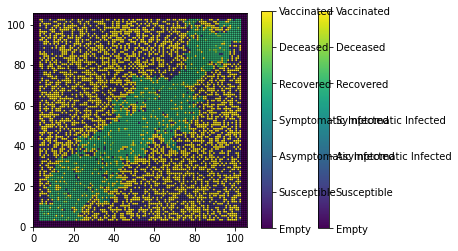

In [ ]:
susceptibleList3 = []
asympInfectedList3 = []
sympInfectedList3 = []
recoveredList3 = []
deceasedList3 = []
vaccinatedList3 = []


def main(initialPercentage, timeSteps):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList3.append(suscep/n)

    asympI = asympInfected(world)[1]
    asympInfectedList3.append(asympI/n)

    sympI = sympInfected(world)[1]
    sympInfectedList3.append(sympI/n)

    recover = recovered(world)[1]
    recoveredList3.append(recover/n)

    dead = deceased(world)[1]
    deceasedList3.append(dead/n)

    vacc = vaccinated(world)[1]
    vaccinatedList3.append(vacc/n)

    stepEvolution(world, populationAgeGroups[2], wantVaccineAgeGroups[2], vaccineRolloutRate, asympCells, sympCells)
  
  createGrid(world)
main(initialPercentage, timeSteps)

tot_inf3 = [sum(x) for x in zip(asympInfectedList3, sympInfectedList3)]

Simulation run for $ageGroup$ = **60-79 years**. This prioritizes the *60-79 years* age group for the vaccine distribution.

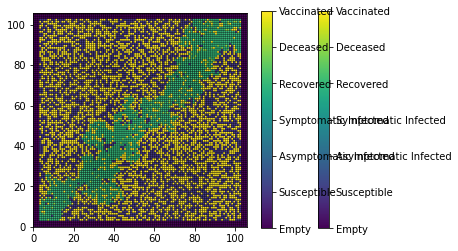

In [ ]:
susceptibleList4 = []
asympInfectedList4 = []
sympInfectedList4 = []
recoveredList4 = []
deceasedList4 = []
vaccinatedList4 = []


def main(initialPercentage, timeSteps):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList4.append(suscep/n)

    asympI = asympInfected(world)[1]
    asympInfectedList4.append(asympI/n)

    sympI = sympInfected(world)[1]
    sympInfectedList4.append(sympI/n)

    recover = recovered(world)[1]
    recoveredList4.append(recover/n)

    dead = deceased(world)[1]
    deceasedList4.append(dead/n)

    vacc = vaccinated(world)[1]
    vaccinatedList4.append(vacc/n)

    stepEvolution(world, populationAgeGroups[3], wantVaccineAgeGroups[3], vaccineRolloutRate, asympCells, sympCells)
  
  createGrid(world)
main(initialPercentage, timeSteps)

tot_inf4 = [sum(x) for x in zip(asympInfectedList4, sympInfectedList4)]

Simulation run for $ageGroup$ = **80+ years**. This prioritizes the *80+ years* age group for the vaccine distribution.

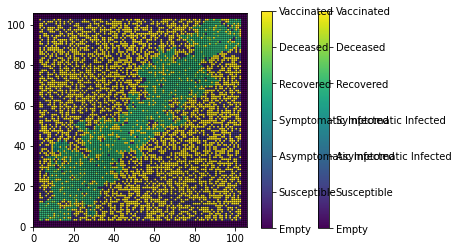

In [ ]:
susceptibleList5 = []
asympInfectedList5 = []
sympInfectedList5 = []
recoveredList5 = []
deceasedList5 = []
vaccinatedList5 = []


def main(initialPercentage, timeSteps):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList5.append(suscep/n)

    asympI = asympInfected(world)[1]
    asympInfectedList5.append(asympI/n)

    sympI = sympInfected(world)[1]
    sympInfectedList5.append(sympI/n)

    recover = recovered(world)[1]
    recoveredList5.append(recover/n)

    dead = deceased(world)[1]
    deceasedList5.append(dead/n)

    vacc = vaccinated(world)[1]
    vaccinatedList5.append(vacc/n)

    stepEvolution(world, populationAgeGroups[4], wantVaccineAgeGroups[4], vaccineRolloutRate, asympCells, sympCells)
  
  createGrid(world)
main(initialPercentage, timeSteps)

tot_inf5 = [sum(x) for x in zip(asympInfectedList5, sympInfectedList5)]

Plot of the **Deaths by Age Group** (cumulative deaths) and **Infections by Age Group** (daily infections) by prioritizing a single age group for the vaccine in each scenario:

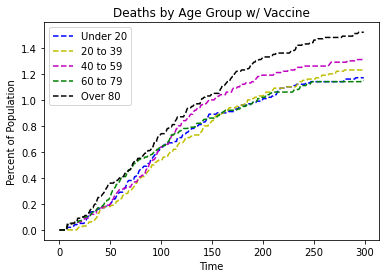

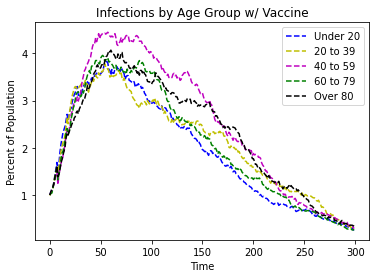

In [ ]:
plt.plot(deceasedList1,'b--',label='Under 20')
plt.plot(deceasedList2,'y--',label='20 to 39')
plt.plot(deceasedList3,'m--',label='40 to 59')
plt.plot(deceasedList4,'g--',label='60 to 79')
plt.plot(deceasedList5,'k--',label='Over 80')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Deaths by Age Group w/ Vaccine")
plt.show()

plt.plot(tot_inf1,'b--',label='Under 20')
plt.plot(tot_inf2,'y--',label='20 to 39')
plt.plot(tot_inf3,'m--',label='40 to 59')
plt.plot(tot_inf4,'g--',label='60 to 79')
plt.plot(tot_inf5,'k--',label='Over 80')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Infections by Age Group w/ Vaccine")
plt.show()

# Cellular Automata simulation of COVID-19 spread without vaccine distribution
This simulation is used as a baseline for comparing results of the effectiveness of prioritizing each of the age groups.

The $stepEvolution$ function is simply edited to remove the *vaccinate cells* step, and instead only account for the asymptomatic and symptomatic spread across cells using the same model parameters as in previous simulations.

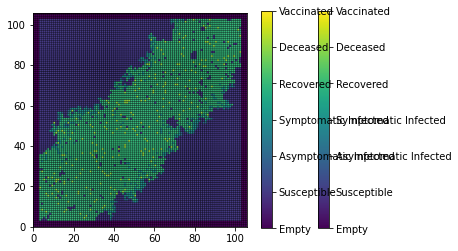

In [ ]:
def stepEvolution(grid, ageGroupPopulation, ageGroupwantVaccine, vaccineRolloutRate, asympCells, sympCells):
  updateAsympInfected(grid, asympCells)
  updateSympInfected(grid, sympCells, recoveryRate, deathRate)

  infectionProbability = infectionSpreadProbability(grid, asympRate, sympRate)

  for (x,y) in zip(*np.where(infectionProbability > 0)):
    number = random.random()

    if (number < infectionProbability[x,y]):
      grid[x,y] = ASYMP_INFECTED


susceptibleList11 = []
asympInfectedList11 = []
sympInfectedList11 = []
recoveredList11 = []
deceasedList11 = []
vaccinatedList11 = []


def main(initialPercentage, timeSteps):
  world, asympCells, sympCells = createWorld(n, int(initialPercentage))

  createGrid(world)

  for i in range(timeSteps):
    suscep = susceptible(world)[1]
    susceptibleList11.append(suscep/n)

    asympI = asympInfected(world)[1]
    asympInfectedList11.append(asympI/n)

    sympI = sympInfected(world)[1]
    sympInfectedList11.append(sympI/n)

    recover = recovered(world)[1]
    recoveredList11.append(recover/n)

    dead = deceased(world)[1]
    deceasedList11.append(dead/n)

    vacc = vaccinated(world)[1]
    vaccinatedList11.append(vacc/n)

    stepEvolution(world, populationAgeGroups[0], wantVaccineAgeGroups[0], vaccineRolloutRate, asympCells, sympCells)
  
  createGrid(world)
main(initialPercentage, timeSteps)

tot_inf11 = [sum(x) for x in zip(asympInfectedList11, sympInfectedList11)]

Plot showing the results of COVID-19 spread without any vaccination distributions:

No handles with labels found to put in legend.


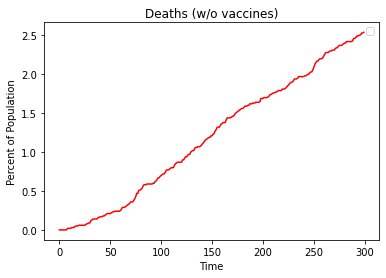

No handles with labels found to put in legend.


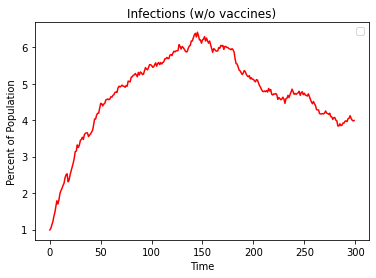

In [ ]:
plt.plot(deceasedList11,'r')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Deaths (w/o vaccines)")
plt.show()

plt.plot(tot_inf11,'r')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Infections (w/o vaccines)")
plt.show()

# Evaluation of Results

Plot of the **Deaths by Age Group** (cumulative deaths) and **Infections by Age Group** (daily infections) by prioritizing a single age group for the vaccine in each scenario, side-by-side with the data of simulating just the COVID-19 spread with no vaccination distribution: 

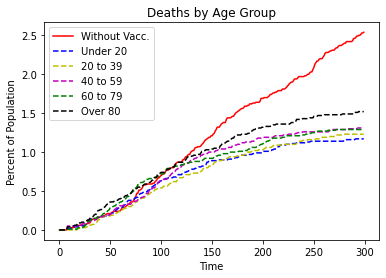

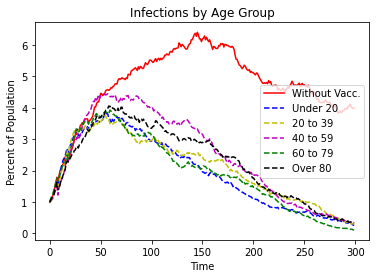

In [ ]:
plt.plot(deceasedList11,'r',label='Without Vacc.')
plt.plot(deceasedList1,'b--',label='Under 20')
plt.plot(deceasedList2,'y--',label='20 to 39')
plt.plot(deceasedList3,'m--',label='40 to 59')
plt.plot(deceasedList4,'g--',label='60 to 79')
plt.plot(deceasedList5,'k--',label='Over 80')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Deaths by Age Group")
plt.show()

plt.plot(tot_inf11,'r',label='Without Vacc.')
plt.plot(tot_inf1,'b--',label='Under 20')
plt.plot(tot_inf2,'y--',label='20 to 39')
plt.plot(tot_inf3,'m--',label='40 to 59')
plt.plot(tot_inf4,'g--',label='60 to 79')
plt.plot(tot_inf5,'k--',label='Over 80')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Infections by Age Group")
plt.show()

The following are observations from the above graphs:


1.   The simulation with no vaccination produces much higher deaths and infections in the population. This is accurate because the introduction of vaccines lowers the spread and infection rate of the virus, hence lowering the percentages of deaths and infections in the population.
2.   The distribution of vaccines "flattens the curve". In the deaths graph, the deaths as a percentage of the population start to flatten out at approx. day 200, where after it is only slowly increasing. In comparison, the simulation with no vaccine distribution is increasing at a high continuous rate throughout the simulation.
3.   The daily infections decrease at a faster rate with the distribution of vaccines. In the infections graph, the infections as a percentage of the population is greatly decreased after a quantifiable amount of people receive the vaccine. It can be seen that by day 300, the infection rate is far below 1% per day. In comparison, the simulation with no vaccine keeps a steady 4-5% daily infections, with no huge decrease in cases. 






Plot of the **Reductions in Deaths by Age Group** (cumulative deaths) and **Reductions in Infections by Age Group** (daily infections) by prioritizing a single age group for the vaccine in each scenario. To calculate the reductions in both deaths and infections, we used the results from the simulation of the COVID-19 spread without vaccine distribution, and took the difference between the baseline and the results gathered from prioritizing each of the age groups:

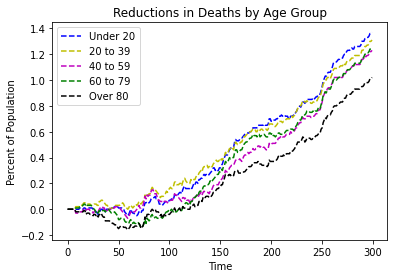

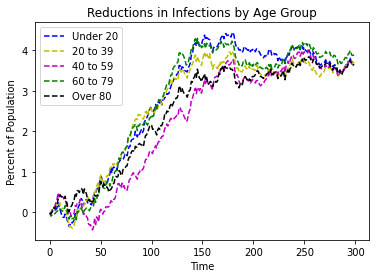

In [ ]:
plt.plot([a_i - b_i for a_i, b_i in zip(deceasedList11, deceasedList1)],'b--',label='Under 20')
plt.plot([a_i - b_i for a_i, b_i in zip(deceasedList11, deceasedList2)],'y--',label='20 to 39')
plt.plot([a_i - b_i for a_i, b_i in zip(deceasedList11, deceasedList3)],'m--',label='40 to 59')
plt.plot([a_i - b_i for a_i, b_i in zip(deceasedList11, deceasedList4)],'g--',label='60 to 79')
plt.plot([a_i - b_i for a_i, b_i in zip(deceasedList11, deceasedList5)],'k--',label='Over 80')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Reductions in Deaths by Age Group")
plt.show()

plt.plot([a_i - b_i for a_i, b_i in zip(tot_inf11, tot_inf1)],'b--',label='Under 20')
plt.plot([a_i - b_i for a_i, b_i in zip(tot_inf11, tot_inf2)],'y--',label='20 to 39')
plt.plot([a_i - b_i for a_i, b_i in zip(tot_inf11, tot_inf3)],'m--',label='40 to 59')
plt.plot([a_i - b_i for a_i, b_i in zip(tot_inf11, tot_inf4)],'g--',label='60 to 79')
plt.plot([a_i - b_i for a_i, b_i in zip(tot_inf11, tot_inf5)],'k--',label='Over 80')
plt.xlabel('Time')
plt.ylabel('Percent of Population')
plt.legend()
plt.title("Reductions in Infections by Age Group")
plt.show()

This is the result of our comprehensive simulation using the Cellular Automata model. The above graphs show the reductions in deaths and infections by prioritizing each age group for the vaccinations, where the higher the line in the graph, the larger the benefit from prioritizing that age group.

**Reductions in Deaths**
<br>
Highest Reduction: Prioritizing the *Under 20* age group
<br>
Lowest Reduction: Prioritizing the *Over 80* age group

**Reductions in Infections**
<br>
Highest Reduction: Prioritizing the *Under 20* age group
<br>
Lowest Reduction: Prioritizing the *40-59* age group

The distribution of vaccines produced very good reductions in deaths and infections, with the prioritization of each age group producing a slightly better or worse reduction. The reduction results for each of the age groups were very close. 

To **minimize the *deaths*** from the COVID-19 virus, it should be preferred to prioritize the ***Under 20* age group**. Conversly, if the *Over 80* age group was prioritized, the reductions in deaths would drop to only approx. 1% as compared to a greater approx. 1.4%. 

To **minimize the *infections*** from the COVID-19 virus, it should be preferred to prioritize either the ***Under 20* or *60-79 years* age groups**. This is because prioritizing each of those age groups produced comparable results of around 4-5% reductions with very little variations between both. Conversly, the *40-59 years* age group should not be prioritized because it reduces the reductions to only around 3.5% at its peak.

These age group prioritizations are intuitive because the Under 20 age group has a large population density, therefore prioritizing them for the vaccine would inevitably reduce the amount of infections and deaths in the population. Moreover, the 40-59 years age group is the least accepting of the vaccine, hence it can be inferred that if they are prioritized then the number of infections will still be high.